### 観測データ
解析に必要なデータ
- XFFTS data
- Encoder data
- weather status
- hosei copy
- obs copy


### 解析フロー

- doppler tracking
- Chopper Wheel
- baseline fitting
- Scaling(from standard object?)
- regrid
    - rms
    - distance
- +header
- 3d-fits

### memo
備忘録
- astropy unitを駆使してわかりやすく書くべき（arcsec/degでバグを増やさないために）
- あらかじめxfftsの分光データをra,dec対応させておく

        
 観測データについて
 - 解析に必要なファイルは？
    - XFFTS分光データ ndf
    - エンコーダ .db
        - あらかじめfk5, galactic に変換して一時ファイルに保存する必要 (npy)
    - weather .???
        - これをどの形式にするか考え中 csv , db
    - 観測時に使用した器差パラメータの入ったファイル hosei_230.txt + alpha
        - これの仕様を早く決定しなくては
        
 これらの複数のファイルをどうやってひとまとめにするか考える必要あり
 - necrecに接続したHDD にndfファイルは保存される
 - その他は全て観測pc
     - nfs mount で観測終了時にHDDにcopyする
     
 - necrec HDD
   - /home/amigos/data/[observation name]/yyyymmhh_HHMMSS/

In [1]:
!ls /Users/shiotani/n2data/

encoder_radec.npy     obsfile               xffts_radec0806.npy
encoder_radec0806.npy otf20190807_n31.n2df  xffts_radec0807.npy
encoder_radec0807.npy xffts_data            xffts_radec2.npy
encoder_radec2.npy    xffts_radec.npy


In [2]:
#radec 変換データ作成
#! python analy_coordinates.py
import sys
sys.path.append("../script/")

In [3]:
import numpy
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
import numba
from astropy.io import fits
###以下独自
import n2df
import read_obsfile
import doppler_nanten

In [4]:
###AzEl情報をradecに変換したものの一時ファイルの読み込み
path_to_xffts_c = "/Users/shiotani/n2data/xffts_radec0807.npy"
path_to_encoder_c = "/Users/shiotani/n2data/encoder_radec0807.npy"
xffts = numpy.load(path_to_xffts_c)
encoder = numpy.load(path_to_encoder_c)

In [5]:
###-30 == 330deg なので。この辺どうしようかね？
#xffts[0] = xffts[0]-360

### gridの作成


In [6]:
#観測プログラムから必要な情報を出す
obsfile_dict = read_obsfile.read("/Users/shiotani/n2data/obsfile/otf_test3_n31.obs")
lamda_on = obsfile_dict["lambda_on"]
beta_on = obsfile_dict["beta_on"]
N = obsfile_dict["N"]
grid = obsfile_dict["grid"]/3600 #[deg]

In [7]:
#今回girdからどこまで離れた範囲まで解析の中に含めるかの値。これは外からいじれる値にしておかないと
offset = 30#[arcsec]
array_num = 2#1~16IF 

In [8]:
#make gird
ragrid = numpy.arange(lamda_on - ((N-1)/2)*grid, lamda_on + ((N-1)/2+1)*grid, grid)
decgrid = numpy.arange(beta_on - ((N-1)/2)*grid, beta_on + ((N-1)/2+1)*grid, grid)
radec_grid = numpy.meshgrid(ragrid, decgrid)

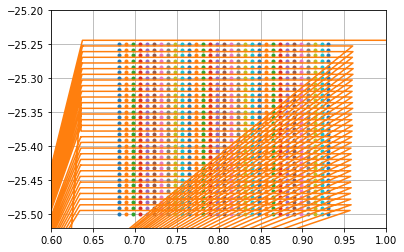

In [9]:
#gridの確認
#girdとXFFTSの点がずれている。これはプロジェクションの問題でcosがかかっていないからか？
plt.plot(radec_grid[0], radec_grid[1], ".")
plt.plot(xffts[0], xffts[1])
#plt.plot(encoder[0], encoder[1],".")
plt.xlim(0.6,1)
plt.ylim(-25.52, -25.2)
plt.savefig("neko.pdf")
plt.grid()
plt.show()

## doppler tracking


In [10]:
#this will be added

### 分光データの読み出し
on/off/hot indexの整理

In [11]:
%%time
n = n2df.Read("/Users/shiotani/n2data/xffts_data/otf20190807_n31.n2df")
array_data = n.read_onearray(array_num)#1IFの分光データ
obs_mode = n.read_obs_mode()#観測モード（ON/OFF/HOT）
scan_num = n.read_scan_num()#スキャンライン（0,1,2,3,4,...）
###array_data, scan_num, obs_mode = n.read_for_otf(1)#3分くらいかかた

100%|██████████| 9399/9399 [00:00<00:00, 708498.32it/s]

CPU times: user 1.36 s, sys: 3.23 s, total: 4.59 s
Wall time: 15.3 s


In [12]:
###index探し
obs_mode = numpy.array(obs_mode)
scan_num = numpy.array(scan_num)

offmask = obs_mode == "OFF"
offindex = numpy.where(offmask == True)

hotmask = obs_mode == "HOT"
hotindex = numpy.where(hotmask == True)

onmask = obs_mode == "ON"
onindex = numpy.where(onmask == True)

max_scannum = numpy.max(scan_num)#Caution! scan num starts from 0, so scan number of 26 indicates 27 times scan

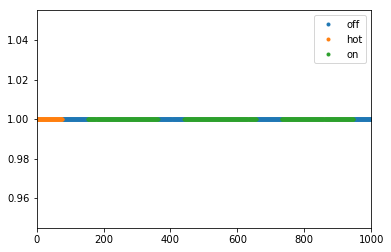

In [13]:
#一応indexの可視化
plt.plot(offindex[0], [1]*len(offindex[0]),"." , label = "off")
plt.plot(hotindex[0], [1]*len(hotindex[0]),"." , label = "hot")
plt.plot(onindex[0], [1]*len(onindex[0]),"." , label = "on")
plt.xlim(0,1000)
plt.legend()
plt.show()

[ 0  0  0 ... 31 31 31]


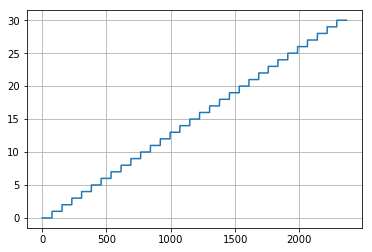

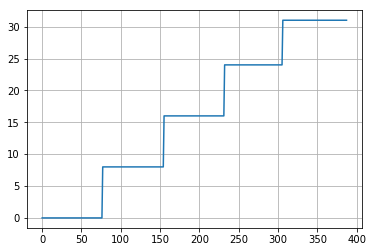

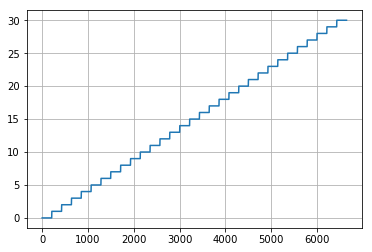

In [14]:
#OFF 点のscan number を取得
scan_num = numpy.array(scan_num)
print(scan_num)
offindex[0]
plt.plot(scan_num[offindex[0]])
plt.grid()
plt.show()

#HOT 点のscan number を取得
scan_num = numpy.array(scan_num)
hotindex[0]
plt.plot(scan_num[hotindex[0]])
plt.grid()
plt.show()

# ON 点のscan number を取得
scan_num = numpy.array(scan_num)
plt.plot(scan_num[onindex[0]])
plt.grid()
plt.show()

### hot/offの積分

In [15]:
#HOT積分
print(numpy.unique(scan_num[hotindex[0]]))#HOT のscan number
hotnum = numpy.unique(scan_num[hotindex[0]])#HOTの数

hotdata = []

for i in tqdm(hotnum):#i = scan number
    mask = scan_num == i#特定のscannumのindexを抜き出す
    index = numpy.where(mask == True)#特定のscannumのindex変数
   ### 
    c = numpy.in1d(index[0], hotindex[0])#特定のscannumのindex&HOT index
    c = numpy.where(c == True)[0]
    ###
    mm = index[0][c]#scan numの値でフィルターしたhot
    #print(mm)
    ###積分
    tmp = [array_data[j] for j in mm]
    hotdata.append(sum(tmp)/len(tmp))
    pass

#下は擬似データの質が低いための処理。将来的に削除
hotdata = numpy.array(hotdata)
hotdata = hotdata + 5000

100%|██████████| 5/5 [00:00<00:00, 89.94it/s]

[ 0  8 16 24 31]


In [16]:
##OFFの積分
print(numpy.unique(scan_num[offindex[0]]))#HOT のscan number
offnum = numpy.unique(scan_num[offindex[0]])#HOTの数

offdata = []
scan_num = numpy.array(scan_num)

for i in tqdm(offnum):
    mask = scan_num == i#特定のscannumのindexを抜き出す
    index = numpy.where(mask == True)#特定のscannumのindex変数
   ### 
    c = numpy.in1d(index[0], offindex[0])#特定のscannumのindex&HOT index
    c = numpy.where(c == True)[0]#scannumとhotで絞ったindex
    mm = index[0][c]#scan numの値でフィルターしたhot
    tmp = [array_data[j] for j in mm]
    offdata.append(sum(tmp)/len(tmp))

  0%|          | 0/31 [00:00<?, ?it/s]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]


100%|██████████| 31/31 [00:00<00:00, 60.42it/s]


Hot のデータはscan line分あるわけでないので補完
Off もscan line 分ある観測プログラムしかないはずだが、一応補完

補完の方法は次のOFF/HOTの点の観測を行うまでは直近のデータを採用する形

In [17]:
d = numpy.unique(scan_num[hotindex[0]])#HOT のscan number
hotdata_ = []
count = 0

for i in tqdm(range(max_scannum)):
        #print(i,count)
        if i == d[count]:
            hotdata_.append(d[count])
            count +=1
        elif i < d[count]:
            hotdata_.append(d[count])
        else:#この例外には入らないはず
            print(i)

100%|██████████| 31/31 [00:00<00:00, 30716.61it/s]


In [18]:
d = numpy.unique(scan_num[offindex[0]])#HOT のscan number
offdata_ = []
count = 0

for i in tqdm(range(max_scannum)):
        #print(i,count)
        if i == d[count]:
            offdata_.append(d[count])
            count +=1
        elif i < d[count]:
            offdata_.append(d[count])
        else:#この例外には入らないはず
            print(i)

100%|██████████| 31/31 [00:00<00:00, 38847.75it/s]


In [19]:
# ###Choper wheel

@numba.jit
def chopper_wheel(on_index, scan_num, temprature = 300):
    #scan_num = n[on_index]["scan_num"]
    #Tastar = (array_data[on_index] - offdata[scan_num])/(hotdata[scan_num] - offdata[scan_num]) * temprature
    Tastar = (array_data[on_index] - offdata[0])/(hotdata[0] - offdata[0]) * temprature#test, this will be deleted（追記：hotdataとoffdataの補完部分作ってないからかな？）
    #print(hotdata[scan_num])
    return Tastar

def calc(i):#on点をscan indexでmaskしchopper wheelする
    mask = scan_num == i#特定のscannumのindexを抜き出す
    index = numpy.where(mask == True)#特定のscannumのindex変数
    c = numpy.intersect1d(index[0], onindex[0])
    return [[j, chopper_wheel(j, i)] for j in c]###j= index 

In [20]:
ondata = [calc(i) for i in tqdm(range(max_scannum+1))]#Chopper Wheelしたやつ

100%|██████████| 32/32 [00:07<00:00, 11.70it/s]


In [21]:
%%time
data_on = {ondata[i][j][0]:ondata[i][j][1] for i in range(len(ondata)) for j in range(len(ondata[i]))}###d[onindex] = onarray

CPU times: user 2.19 ms, sys: 635 µs, total: 2.82 ms
Wall time: 2.99 ms


In [22]:
#距離による重みつけ関数１
#sigma == ビームサイズ
def gauss(x, a = 1, mu = 0, sigma = 160):
    return a * numpy.exp(-(x - mu)**2 / (2*sigma**2))

#距離による重みつけ関数2 関数系わからないので今はgaussianだけど修正
def bessel_gauss(x, a = 1, mu = 0, sigma = 160):
    return a * numpy.exp(-(x - mu)**2 / (2*sigma**2))

#球面なのでRA方向の長さがDECで変わります。なのでRA-DEC平面での距離(角度)を出すには、RAをcos(DEC)で割る必要があります。
def calc_distance(d1, d2):
    #d1 = [ra, dec] #deg   
    factor = 3600
    d1[0] = d1[0]*factor
    d1[1] = d1[1]*factor
    d2[0] = d2[0]*factor
    d2[1] = d2[1]*factor
    return gauss(((d1[0] - d2[0])**2 + (d1[1] - d2[1])**2)**0.5)

## Baseline fitting

In [37]:
#baseline fitting parameter
center = 8000
width = 1000
start = 3000
end = 30000

#baseline fitting function
def f(x, a, b, c):
    return a*x**2 + b*x + c

#ch
xindex = numpy.linspace(0, 32768, 32768)

#baseline fitting index
index1 = int(start)
index2 = int(center - width/2)
index3 = int(center + width/2)
index4 = int(end)
print(index1, index2, index3, index4)
#
rTaslist_tmp = []

#
for i in tqdm(data_on.keys()):
    #print(i)
    data_on[i] = data_on[i] + offset#shiotani added 
    tmpdata_y1 = data_on[i][index1:index2]
    tmpdata_y2 = data_on[i][index3:index4]
    tmpdata_x1 = xindex[index1:index2]
    tmpdata_x2 = xindex[index3:index4]
    x = numpy.concatenate([tmpdata_x1, tmpdata_x2])
    y = numpy.concatenate([tmpdata_y1, tmpdata_y2])
    param = numpy.polyfit(x, y, 2)
    rTas = data_on[i] - f(xindex, *param)
    rTaslist_tmp.append(rTas)

rTaslist = numpy.array(rTaslist_tmp)

3000 

100%|██████████| 6644/6644 [00:34<00:00, 200.55it/s]


7500 8500 30000


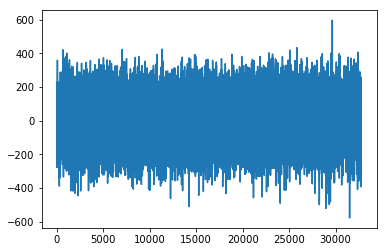

0.13217583213548278
59.866196
[ 8.22960711e-09 -2.59975709e-04  6.09368169e+01]
59.387836


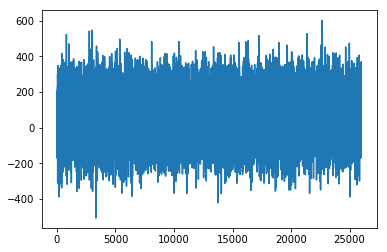

In [38]:
%matplotlib inline
plt.plot(rTaslist[201])
#plt.plot(data_on[155])
plt.show()

print(numpy.average(rTaslist[0]))
print(numpy.average(data_on[154]))
print(param)

#plt.plot(x)
plt.plot(y)
print(numpy.average(y))

In [39]:
a = numpy.array([0,1,2])
b = numpy.array([0,1,2])
c = numpy.concatenate([a,b])
c

array([0, 1, 2, 0, 1, 2])

## grid内のデータ探索

あるgridに採用するデータのindexを求める

In [40]:
%time
index_list = []
for i in tqdm(range(31)):
    for j in range(31):
       # print(ragrid[i], decgrid[j])
        index1 = numpy.where((ragrid[i]-(offset/3600)<xffts[0]) & ((ragrid[i] + (offset/3600)>xffts[0])))
        index2 = numpy.where((decgrid[j]-(offset/3600)<xffts[1]) & ((decgrid[j] + (offset/3600)>xffts[1])))
        index_ = [i in index2[0] for i in index1[0]]
        index_ = numpy.array(index_)
        index_1and2 = numpy.where(index_ == True)
        index_1and2 = index1[0][index_1and2]
        index_list.append(index_1and2)


  6%|▋         | 2/31 [00:00<00:01, 16.74it/s]

CPU times: user 9 µs, sys: 3 µs, total: 12 µs
Wall time: 67 µs


100%|██████████| 31/31 [00:02<00:00, 14.94it/s]


In [41]:
#print(index_list)###どこのgridには何のindexのデータを含めるかというindex

In [42]:
#どこのデータまでがあるgridのデータかというやつ
# %matplotlib notebook
# for i in index_list[4:5]:
#     plt.plot(xffts_ra[i], xffts[1][i], ".", alpha = 0.5)
# plt.plot(xffts_ra, xffts[1], ".", alpha = 0.1)
# plt.xlim(-31,-30.6)
# plt.ylim(-25.23, -25.52)
# plt.grid()
# plt.show()

### xfftsデータの確認

### データをgridに入れる

本番はもう少し賢く書くけど、ひとまず

In [43]:
%%time
#cubeデータの作成
data_c = numpy.zeros((31, 31, 32768))#(ra, dec, ch)
index_list2 = numpy.reshape(index_list, (31,31))#index listの2次元化（これは前処理しておく） #これは正しいか？

## Chopper wheelしたデータをdatacubeに入れる
for i in tqdm(range(31)):#ra
    for j in range(31):#dec
        try:
            sum_list = []
            for k in index_list2[i][j]:
                dist = calc_distance([ragrid[i], decgrid[j]], [xffts[0][k], xffts[1][k]])
                sum_list.append(data_on[k]/dist**2)
            data_c[i][j] = sum(sum_list)/len(sum_list)
        except Exception as e:
            print("[{},{}], {}".format(i,j,e), end = "")

100%|██████████| 31/31 [00:09<00:00,  3.56it/s]

CPU times: user 2 s, sys: 1.7 s, total: 3.7 s
Wall time: 9.75 s


距離を考慮すると...

### astropyでfitsに書き出す

In [44]:
#3軸の入れ替え。
data_c = numpy.swapaxes(data_c, 0,2)
#data_c = numpy.swapaxes(data_c, 2,1)
print(numpy.shape(data_c))#軸の入れ替えの確認

(32768, 31, 31)


ヘッダーの作成

In [45]:
header_dict = {
"object" : obsfile_dict["object"],
"crval1" : obsfile_dict["lambda_on"],
"cdelt1" : obsfile_dict["grid"]/3600,
"crpix1" : obsfile_dict["N"]-1/2,#中心ピクセル
"crval2" : obsfile_dict["beta_on"],
"cdelt2" : obsfile_dict["grid"]/3600,
"crpix2" : obsfile_dict["N"]-1/2 #中心ピクセル
}

In [46]:
temp = """
SIMPLE  =                    T                                                  
BITPIX  =                  -64                                                  
NAXIS   =                    3                                                  
NAXIS1  =                  31                                                 
NAXIS2  =                  31                                                 
NAXIS3  =                   32768                                                  
OBJECT  = '{object}              '                                                  
TELESCOP= 'NANTEN2            '                                                  
INSTRUME= 'MULT2-11          '                                                  
OBSERVER= 'z7510rk           '                                                  
DATE-OBS= '2007-12-30        '                                                  
DATE-MAP= '2012-01-19        '                                                  
BSCALE  =    0.10000000000E+01                                                  
BZERO   =    0.00000000000E+01                                                  
BUNIT   = 'K                 '                                                  
EPOCH   =    0.20000000000E+04                                                  
OBSRA   =    8.38104170000E+01                                                  
OBSDEC  =   -5.37511100000E+00                                                  
DATAMAX =    1.16774444580E+02                                                  
DATAMIN =   -8.33924560547E+01                                                  
CTYPE1  = 'RA---GLS          '                                                  
CRVAL1  =    {crval1}                                                  
CDELT1  =    {cdelt1}                                                  
CRPIX1  =      {crpix1}
CROTA1  =     0.0000000000E+00                                                  
CTYPE2  = 'DEC--GLS          '                                                  
CRVAL2  =   {crval2}                                                  
CDELT2  =   {cdelt2}                                               
CRPIX2  =     {crpix2}                                               
CROTA2  =     0.0000000000E+00                                                  
CTYPE3  = 'VELO-LSR          '                                                  
CRVAL3  =    2.50000000000E+02                                                  
CDELT3  =    5.00000000000E+02                                                  
CRPIX3  =    1.00000000000E+00                                                  
CROTA3  =    0.00000000000E+00                                                  
BLANK   =   -1.00000000000E+00 """.format(**header_dict)

In [47]:
target_header = fits.Header.fromstring(temp, sep = "\n")

In [48]:
#書き出し
hdu = fits.PrimaryHDU(data_c, target_header)
hdulist = fits.HDUList([hdu])
hdulist.writeto("test3.fits", overwrite = True)

In [49]:
##読み込み
hdu_list = fits.open("test3.fits")
hdu_r = hdu_list[0]
data = hdu_r.data
header = hdu_r.header

In [50]:
!ps aux | grep jupyter

shiotani        28303   3.3  0.1  2473964   7396 s006  S+    2:55AM   0:19.76 /Users/shiotani/.pyenv/versions/anaconda3-4.3.1/bin/python /Users/shiotani/.pyenv/versions/anaconda3-4.3.1/bin/jupyter-notebook
shiotani        29461   0.0  0.0  2434840    780 s017  S+    1:29PM   0:00.00 grep jupyter
shiotani        29459   0.0  0.0  2454892   1108 s017  Ss+   1:29PM   0:00.03 /bin/sh -c ps aux | grep jupyter
